# Part 1, Data Cleaning + LDA

In [1]:
# Imstalling necessary libraries

!pip install texthero
!pip install gensim
!pip install cython
!pip install pandarallel
!pip install pyLDAvis
!pip install textblob
!pip install HTML

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import modules & set up logging

import os
import pandas as pd
from pandarallel import pandarallel
import texthero as hero
import re
from pprint import pprint

import nltk as nltk
import nltk.corpus  
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.wordnet import WordNetLemmatizer
# import cudf

import spacy 
from spacy import displacy
from textblob import TextBlob
import string

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from nltk.tokenize import sent_tokenize
# from textblob import TextBlob
import gensim

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 6


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-05-27 17:32:47.533664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 17:32:48.696451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:50.430262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:50.431168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

'/device:GPU:0'

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.020220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.020924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14636 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-05-27 17:32:54.049995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.050968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.051702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.052481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:32:54.053143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8739996799382242903
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15347744768
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8284931826208209638
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

In [6]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Gen RAM Free: 79.8 GB  |     Proc size: 1.0 GB
GPU RAM Free: 15687MB | Used: 473MB | Util   3% | Total     16160MB


### Loading Data and Cleaning

In [7]:
# Downloading Data

df_news_final_project = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', \
                                     orient='records', lines=True) 

In [8]:
pd.set_option('display.max_colwidth', 500)

In [9]:
df_news_final_project.head()

,date,language,title,text
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...
1,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students..."
2,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD"
3,2022-01-06,english,Trump’s Solution for Chicago Public Schools? King Solomon Blog,"Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to the students so they can get out of these failing government schools!” Trump said in a statement.”\nThe Purpose of This Post\nIs to relate an ancient wisdom proverb to Trump’s sol..."
4,2022-01-06,english,"Family, friends, colleagues gathering today at South Side church to attend funeral services for Chicago firefighter Mashawn Plummer","The neighbors near Mashawn Plummer’s Portage Park firehouse knew him because he often sat outside, a friendly presence at the station. He showed up early for his shifts, ready to do a job he was thrilled to have, friends and family recalled.\nChicago Firefighter/EMT Mashawn Plummer of Engine 94. (Chicago Fire Department) Hundreds of Chicago firefighters joined family and friends on Thursday to lay Plummer to rest after he died in December battling an apartment fire on the Northwest Side. The..."


In [10]:
# Checking for duplicate text after removing leading and trailing spaces

df_news_final_project['text_new'] = df_news_final_project['text'].str.strip()
df_news_final_project[df_news_final_project['text_new'].duplicated()]

,date,language,title,text,text_new
426,2022-05-03,english,Chicago Cubs Ian Happ and Justin Steele use team's day off to get engaged to their girlfriends,"The [Chicago Cubs](/mlb/team/_/name/chc/chicago-cubs) have lost nine of their past 12 games and are 9-13 on the season, third in the NL Central. The Cubs sit at [No. 23 in ESPN's power rankings](/mlb/story/_/id/33815384/mlb-power-rankings-week-3-which-hot-al-team-challenging-our-no-1-spot) , and ESPN's David Schoenfield has given them a [D grade](/mlb/insider/story/_/id/33842026/first-month-grades-all-30-mlb-teams-handing-an-f-minus-minus) for their first month of the season. Ah, but love co...","The [Chicago Cubs](/mlb/team/_/name/chc/chicago-cubs) have lost nine of their past 12 games and are 9-13 on the season, third in the NL Central. The Cubs sit at [No. 23 in ESPN's power rankings](/mlb/story/_/id/33815384/mlb-power-rankings-week-3-which-hot-al-team-challenging-our-no-1-spot) , and ESPN's David Schoenfield has given them a [D grade](/mlb/insider/story/_/id/33842026/first-month-grades-all-30-mlb-teams-handing-an-f-minus-minus) for their first month of the season. Ah, but love co..."
607,2022-04-27,english,Chicago Bears Wide Receiver Byron Pringle Arrested In Florida: Report | News Radio 920 AM & 104.7 FM,"Photo: Getty Images\nChicago Bears wide receiver Byron Pringle was arrested in Florida on Saturday (April 23) after being pulled over by Florida Highway Patrol in Pasco County.\nPolice said Pringle was doing donuts in his 2016 Challenger SRT Hellcat around 6 p.m. while a child was in the car . The 28-year-old NFL player was seen burning rubber, spinning his vehicle in circles on a public road, according to an incident report obtained by TMZ . Pringle was driving with two other passengers –– ...","Photo: Getty Images\nChicago Bears wide receiver Byron Pringle was arrested in Florida on Saturday (April 23) after being pulled over by Florida Highway Patrol in Pasco County.\nPolice said Pringle was doing donuts in his 2016 Challenger SRT Hellcat around 6 p.m. while a child was in the car . The 28-year-old NFL player was seen burning rubber, spinning his vehicle in circles on a public road, according to an incident report obtained by TMZ . Pringle was driving with two other passengers –– ..."
643,2022-01-06,english,"""Chicago P.D."" Home Safe - English (1CD ) - subtitles","Buy at Amazon\nDownload (beta)\nWatch online:\nUploaded from OpenSubtitles-Uploader v2.5.0 developed by MrVaykadji\nlog-in to post comments.\nTo download our subtitles, install Chrome extension; click on1. ""Add to Chrome""\n2. ""Add Extension""\nIf you install our extension you will remove all ads and waiting time on this websiteThank you !\nTo download our subtitles, install Firefox add-on; click on1. ""Add to Firefox""\n2. ""Add""\nIf you install our extension you will remove all ads and waiting ...","Buy at Amazon\nDownload (beta)\nWatch online:\nUploaded from OpenSubtitles-Uploader v2.5.0 developed by MrVaykadji\nlog-in to post comments.\nTo download our subtitles, install Chrome extension; click on1. ""Add to Chrome""\n2. ""Add Extension""\nIf you install our extension you will remove all ads and waiting time on this websiteThank you !\nTo download our subtitles, install Firefox add-on; click on1. ""Add to Firefox""\n2. ""Add""\nIf you install our extension you will remove all ads and waiting ..."
724,2022-01-06,english,"Arizona Governor Values Children and Health, Unlike Chicago Teachers","Comment on this Article Via Your Disqus Account\nConservative News Clearing House\nStop by our forum, where fellow conservatives are posting and sharing content important to preserving the American way of life. Join us (for free) today and make your voice heard!","Comment on this Article Via Your Disqus Account\nConservative News Clearing House\nStop by our forum, where fellow conservatives are posting and sharing content important to preserving the American way of life. Join us (for free) today and make your voic

In [11]:
# Looking at a sample case

df_news_final_project[df_news_final_project['text'] == 'Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.']

,date,language,title,text,text_new
2880,2022-03-04,english,"The Ogden Chicago - Chicago, IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
9043,2022-03-01,english,"Restaurante The Ogden Chicago - Chicago, , IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
9289,2022-03-02,english,The Ogden Chicago,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
9853,2022-03-01,english,"The Ogden Chicago - Chicago, IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
10203,2022-03-06,english,"The Ogden Chicago Restaurante - Chicago, IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
...,...,...,...,...,...
187313,2022-03-04,english,The Ogden Chicago - Chicago,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
191925,2022-03-08,english,"The Ogden Chicago Restaurante - Chicago, IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
195583,2022-02-27,english,"Restaurante The Ogden Chicago - Chicago, , IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.
195661,2022-02-26,english,"The Ogden Chicago - Chicago, IL | OpenTable",Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.,Enjoyed the varied menu. The nacho tower presentation was fun! Definitely on our list when going to United Center.


In [12]:
# Dropping articles with duplicate text

df_news_final_project = df_news_final_project.drop_duplicates(subset=['text_new']).reset_index(drop=["index"])

In [13]:
df_news_final_project.shape

(187910, 5)

In [14]:
df_news_final_project.iloc[0,2], df_news_final_project.iloc[1,2]

('No deal, no school: Chicago cancels classes for a 2nd day',
 'No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com')

In [15]:
# From the first two rows, we see there is some duplication - we split the title using '|' as a delimiter because the only difference in titles is the source of news after '|'
# Also, from the above cell, we see that there is a difference of trailing spaces

df_news_final_project['title_new'] = df_news_final_project['title'].str.split('|', expand=True).iloc[:,0]
df_news_final_project['title_new'] = df_news_final_project['title_new'].str.strip()

In [16]:
# Examining the duplicate rows based on title

df_news_final_project[df_news_final_project['title_new'].duplicated()]

,date,language,title,text,text_new,title_new
1,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","No deal, no school: Chicago cancels classes for a 2nd day"
52,2022-05-03,english,What Does Alcohol Detox In Chicago Mean?,Our New Beginnings Alcohol & Drug Rehab Ideas Table of Contents10 Simple Techniques For Alcohol Rehab In ChicagoAlcohol And Drug Rehab Center In Chicago for DummiesThe 7-Minute Rule for New Beginnings Alcohol And Drug Rehab CenterThe 9-Minute Rule for Alcohol Detox In ChicagoThe Best Strategy To Use For New Beginnings https://messiahcmoop.thebindingwiki.com/6108821/the_2_minute_rule_for_new_beginnings_alcohol_detox_center,Our New Beginnings Alcohol & Drug Rehab Ideas Table of Contents10 Simple Techniques For Alcohol Rehab In ChicagoAlcohol And Drug Rehab Center In Chicago for DummiesThe 7-Minute Rule for New Beginnings Alcohol And Drug Rehab CenterThe 9-Minute Rule for Alcohol Detox In ChicagoThe Best Strategy To Use For New Beginnings https://messiahcmoop.thebindingwiki.com/6108821/the_2_minute_rule_for_new_beginnings_alcohol_detox_center,What Does Alcohol Detox In Chicago Mean?
115,2022-05-03,english,The Best Strategy To Use For Alcohol Rehab In Chicago,All About The Best Drug Rehab Center In Chicago Illinois\nTable of Contents [Not known Factual Statements About Alcohol And Drug Rehab Center In Chicago ](#content-section-0) [A Biased View of Alcohol Rehab In Chicago](#content-section-1) [Examine This Report on New Beginnings Drug Detox Center](#content-section-2) [Little Known Facts About Alcohol And Drug Rehab Center In Chicago.](#content-section-3) [What Does New Beginnings Alcohol And Drug Rehab Center In Chicago Do?](#content-section-4...,All About The Best Drug Rehab Center In Chicago Illinois\nTable of Contents [Not known Factual Statements About Alcohol And Drug Rehab Center In Chicago ](#content-section-0) [A Biased View of Alcohol Rehab In Chicago](#content-section-1) [Examine This Report on New Beginnings Drug Detox Center](#content-section-2) [Little Known Facts About Alcohol And Drug Rehab Center In Chicago.](#content-section-3) [What Does New Beginnings Alcohol And Drug Rehab Center In Chicago Do?](#content-section-4...,The Best Strategy To Use For Alcohol Rehab In Chicago
168,2022-01-06,english,Chicago schools shut for 2nd day over virus safety protocols,"CHICAGO — Thousands of Chicago students remained out of school for a second straight day Thursday after leaders of the nation’s third-largest school district failed to resolve a deepening clash with the influential teachers union over COVID-19 safety protocols.\nThe Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate.\nThe move just two days after students returned from winter br...","CHICAGO — Thousands of Chicago students remained out of school for a second straight day Thursday after lea

In [17]:
# Examining a sample where title is duplicated - it looks like there are multiple articles with same information from different news sources. 

test = df_news_final_project[df_news_final_project['title_new'] == 'No deal, no school: Chicago cancels classes for a 2nd day']
test = test.reset_index(drop=['index'])
test

,date,language,title,text,text_new,title_new
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,"No deal, no school: Chicago cancels classes for a 2nd day"
1,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","No deal, no school: Chicago cancels classes for a 2nd day"
2,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | | kptv.com",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district.\nThe Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols ...,CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district.\nThe Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols ...,"No deal, no school: Chicago cancels classes for a 2nd day"
3,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district.\nThe Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while

In [18]:
test.iloc[0,-3][0:55], test.iloc[1,-3][0:55]

# Most of the text is same except some URL and bracket differences
# For the same title, will look at first few words of text - if same, we drop duplicates

('CHICAGO (AP) — Chicago school leaders canceled classes ',
 'CHICAGO (AP) — Chicago school leaders canceled classes ')

In [19]:
# choosing first 55 characters of the text

df_news_final_project['text_new_2'] = df_news_final_project['text_new'].apply(lambda x: x[0:55])

In [20]:
df_news_final_project[['title_new', 'text_new_2']].duplicated().sum() # there are 21636 duplicates 

21636

In [21]:
# Examining the duplicate rows

df_news_final_project[df_news_final_project[['title_new','text_new_2']].duplicated()]

,date,language,title,text,text_new,title_new,text_new_2
1,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students...","No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes
291,2022-01-11,english,Chicago union leaders OK plan to resume in-person class,"CHICAGO (AP) — Students are poised to return to Chicago Public Schools after leaders of the teachers union approved a plan with the nation's third-largest district over COVID-19 safety protocols, ending a bitter standoff that canceled classes for five days.\nWhile school districts nationwide have faced similar concerns due to skyrocketing COVID-19 cases, the labor fight in union-friendly Chicago amplified concerns over remote learning and other pandemic issues.\nThe deal approved late Monday...","CHICAGO (AP) — Students are poised to return to Chicago Public Schools after leaders of the teachers union approved a plan with the nation's third-largest district over COVID-19 safety protocols, ending a bitter standoff that canceled classes for five days.\nWhile school districts nationwide have faced similar concerns due to skyrocketing COVID-19 cases, the labor fight in union-friendly Chicago amplified concerns over remote learning and other pandemic issues.\nThe deal approved late Monday...",Chicago union leaders OK plan to resume in-person class,CHICAGO (AP) — Students are poised to return to Chicago
384,2022-01-06,english,Chicago schools shut for 2nd day over virus safety protocols,"CHICAGO (AP) — Hundreds of thousands of Chicago students remained out of school for a second straight day Thursday after leaders of the nation's third-largest school district failed to resolve a deepening clash with the influential teachers union over COVID-19 safety protocols.{/p}\nThe Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate.{/p}\nThe move just two days after student...","CHICAGO (AP) — Hundreds of thousands of Chicago students remained out of school for a second straight day Thursday after leaders of the nation's third-largest school district failed to resolve a deepening clash with the influential teachers union over COVID-19 safety protocols.{/p}\nThe Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate.{/p}\nThe move just two days after student...",Chicago schools shut for 2nd day over virus safety protocols,CHICAGO (AP) — Hundreds of thousands of Chicago student
430,2022-01-11,english,"John Prunskis, M.D. – Illinois Pain and Spine Institute Named Castle Connolly Top Pain Doctor for the 13th Time","John Prunskis, M.D. – Illinois Pain and Spine Institute Named Castle Connolly Top Pain Doctor for the 13th Time\nChicago, IL, USA – January 10, 2022 – Illinois Pain and Spine In

In [22]:
# Dropping duplicates based on titles with text having same first 55 words

df_news_new = df_news_final_project.drop_duplicates(subset=['title_new', 'text_new_2']).reset_index(drop=["index"])

In [23]:
df_news_final_project.shape

(187910, 7)

In [24]:
df_news_new.shape

(166274, 7)

In [25]:
df_news_new.language.value_counts()

english    166274
Name: language, dtype: int64

In [26]:
df_news_new.duplicated().sum()

0

In [27]:
df_news_new.head()

,date,language,title,text,text_new,title_new,text_new_2
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes
1,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD","Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD",Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voig
2,2022-01-06,english,Trump’s Solution for Chicago Public Schools? King Solomon Blog,"Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to the students so they can get out of these failing government schools!” Trump said in a statement.”\nThe Purpose of This Post\nIs to relate an ancient wisdom proverb to Trump’s sol...","Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to the students so they can get out of these failing government schools!” Trump said in a statement.”\nThe Purpose of This Post\nIs to relate an ancient wisdom proverb to Trump’s sol...",Trump’s Solution for Chicago Public Schools? King Solomon Blog,Wise of Foolish?\nThe Chicago Tribune article titled: Ch
3,2022-01-06,english,"Family, friends, colleagues gathering today at South Side church to attend funeral services for Chicago firefighter Mashawn Plummer","The neighbors near Mashawn Plummer’s Portage Park firehouse knew him because he often sat outside, a friendly presence at the station. He showed up early for his shifts, ready to do a job he was thrilled to have, friends and family recalled.\nChicago Firefighter/EMT Mashawn Plummer of Engine 94. (Chicago Fire Department) Hundreds of Chicago firefighters joined family and friends on Thursday to lay Plummer to rest after he died in December battling an apartment fire on the Northwest Side. The...","The neighbors near Mashawn Plummer’s Portage Park firehouse knew him because he often sat outside, a friendly presence at the station. He showed 

In [28]:
df_news_new.tail()

,date,language,title,text,text_new,title_new,text_new_2
166269,2022-03-05,english,"Fed to Raise Rates, Won’t Be as Restrictive as 1990s: Chicago Fed President","Fed to Raise Rates, Won’t Be as Restrictive as 1990s: Chicago Fed President Posted by on March 5, 2022 9:23 amTags: Categories: Breaking News Epoch Times News\nFederal Reserve Bank of Chicago President Charles Evans on Friday said the U.S. central bank is on track to raising rates this year, though it may be “more than I think is essential” to do so at every policy-setting meeting. “By the end of the year when we are closer to neutral we are going to have a better fix on how far we have to g...","Fed to Raise Rates, Won’t Be as Restrictive as 1990s: Chicago Fed President Posted by on March 5, 2022 9:23 amTags: Categories: Breaking News Epoch Times News\nFederal Reserve Bank of Chicago President Charles Evans on Friday said the U.S. central bank is on track to raising rates this year, though it may be “more than I think is essential” to do so at every policy-setting meeting. “By the end of the year when we are closer to neutral we are going to have a better fix on how far we have to g...","Fed to Raise Rates, Won’t Be as Restrictive as 1990s: Chicago Fed President","Fed to Raise Rates, Won’t Be as Restrictive as 1990s: C"
166270,2022-03-05,english,EXPLAINER: How Dangerous Was Russia’s Nuclear Plant Strike? | Chicago News | WTTW,"This image made from a video released by Zaporizhzhia nuclear power plant shows bright flaring object landing in grounds of the nuclear plant in Enerhodar, Ukraine Friday, March 4, 2022. (Zaporizhzhia nuclear power plant via AP)\nBANGKOK (AP) — Europe’s largest nuclear power plant was hit by Russian shelling early Friday, sparking a fire and raising fears of a disaster that could affect all of central Europe for decades, like the 1986 Chernobyl meltdown.\nThanks to our sponsors: View all spo...","This image made from a video released by Zaporizhzhia nuclear power plant shows bright flaring object landing in grounds of the nuclear plant in Enerhodar, Ukraine Friday, March 4, 2022. (Zaporizhzhia nuclear power plant via AP)\nBANGKOK (AP) — Europe’s largest nuclear power plant was hit by Russian shelling early Friday, sparking a fire and raising fears of a disaster that could affect all of central Europe for decades, like the 1986 Chernobyl meltdown.\nThanks to our sponsors: View all spo...",EXPLAINER: How Dangerous Was Russia’s Nuclear Plant Strike?,This image made from a video released by Zaporizhzhia n
166271,2022-03-05,english,"Loyola Chicago vs. Northern Iowa – MVC Tournament – Predictions, Betting Lines, Odds and Trends","The No. 4 seed Loyola Chicago Ramblers (23-7, 13-5 MVC) are 4-point favorites in the MVC Tournament over the top-seeded Northern Iowa Panthers (19-10, 14-4 MVC) on Saturday at Enterprise Center. The game tips at 3:30 PM, with both teams hoping to move one step closer to an automatic berth in the NCAA Tournament bracket.\nLoyola Chicago vs. Northern Iowa Predictions\nLoyola Chicago vs. Northern Iowa Betting Odds\n|Favorite||Spread||Total|\n|Loyola Chicago||-4||139.5 points|\nLoyola Chicago vs...","The No. 4 seed Loyola Chicago Ramblers (23-7, 13-5 MVC) are 4-point favorites in the MVC Tournament over the top-seeded Northern Iowa Panthers (19-10, 14-4 MVC) on Saturday at Enterprise Center. The game tips at 3:30 PM, with both teams hoping to move one step closer to an automatic berth in the NCAA Tournament bracket.\nLoyola Chicago vs. Northern Iowa Predictions\nLoyola Chicago vs. Northern Iowa Betting Odds\n|Favorite||Spread||Total|\n|Loyola Chicago||-4||139.5 points|\nLoyola Chicago vs...","Loyola Chicago vs. Northern Iowa – MVC Tournament – Predictions, Betting Lines, Odds and Trends","The No. 4 seed Loyola Chicago Ramblers (23-7, 13-5 MVC)"
166272,2022-03-05,english,"DraftKings Illinois Promo Code: $1,050 Bonus and Online Registration - NewsBreak","Remember to check out the DraftKings Illinois page! You’ll find the DraftKings

In [29]:
# There are some articles contining the words 'ads', 'javascript', 'offsetwidth', 'css'
# We analyze them further

ads = pd.DataFrame(df_news_new['text_new'].apply(lambda x: re.findall(" ads", str(x))))
ads = ads[ads['text_new'].apply(lambda x: len(x)>0)]
print(ads.shape)
ads.head(10)

(846, 1)


,text_new
93,[ ads]
97,[ ads]
101,[ ads]
305,"[ ads, ads]"
688,"[ ads, ads]"
726,[ ads]
799,[ ads]
917,"[ ads, ads]"
946,[ ads]
1003,[ ads]


In [30]:
df_news_new.iloc[97,4]

'Thanks for visiting\nThe use of software that blocks ads hinders our ability to serve you the content you came here to enjoy.\nWe ask that you consider turning off your ad blocker so we can deliver you the best experience possible while you are here.\nThank you for your support!'

In [31]:
df_news_new.iloc[305,4]

'Buy at Amazon\nDownload (beta)\nWatch online:\nUploaded from OpenSubtitles-Uploader v2.5.0 developed by MrVaykadji\nlog-in to post comments.\nTo download our subtitles, install Chrome extension; click on1. "Add to Chrome"\n2. "Add Extension"\nIf you install our extension you will remove all ads and waiting time on this websiteThank you !\nTo download our subtitles, install Firefox add-on; click on1. "Add to Firefox"\n2. "Add"\nIf you install our extension you will remove all ads and waiting time on this websiteThank you !\nYour download will start in seconds\nSupport us |\nDownload |\nFAQ |\nStatistics |\nContact |\nDisclaimer |\nDevelopers |\nDMCA\n|\nAdmins\n© 2006-2022opensubtitles.org'

In [32]:
df_news_new.iloc[917,4]

'Support our war chest with a monthly subscription and enjoy a faster, minimal Revolver.News reading experience.\n$5.00 / month [Hide ads for $5/month](?add-to-cart=72549)\n$49.00 / year [Hide ads for $49/year](?add-to-cart=72548)\nWe use cookies to enhance your experience. By continuing to visit this site you agree to our use of cookies.'

In [33]:
# The ads look simply like ads, and seem irrelevant to the analysis. We will therefore remove these 846 articles.

# Inspecting javascript cases
javascript = pd.DataFrame(df_news_new['text_new'].apply(lambda x: re.findall("javascript", str(x))))
javascript = javascript[javascript['text_new'].apply(lambda x: len(x)>0)]
print(javascript.shape)
javascript.head(10)

(1176, 1)


,text_new
307,"[javascript, javascript, javascript, javascript, javascript, javascript]"
558,"[javascript, javascript, javascript, javascript]"
629,"[javascript, javascript, javascript, javascript]"
712,"[javascript, javascript, javascript, javascript]"
944,"[javascript, javascript, javascript, javascript]"
1002,"[javascript, javascript]"
1268,"[javascript, javascript, javascript, javascript, javascript, javascript, javascript, javascript]"
1302,"[javascript, javascript, javascript, javascript]"
1611,"[javascript, javascript, javascript, javascript]"
1653,"[javascript, javascript, javascript, javascript]"


In [34]:
df_news_new.iloc[307,4]

'[Video](javascript:void(0)) Fox News Flash top headlines are here. Check out what’s clicking on Foxnews.com. Three minors have been charged in connection with a Tuesday afternoon [shooting](javascript:void(0)) at an [Illinois](javascript:void(0)) high school parking lot that left two teenagers injured. The male suspects, ages 15, 16, and 17, all face two counts each of attempted [murder](javascript:void(0)) and aggravated discharge of a weapon, the Rockford Police Department said. [SUSPECT IN ILLINOIS DEPUTY’S DEATH HAS MORE CHARGES ADDED AFTER MULTI-STATE CRIME SPREE](javascript:void(0)) Two teenagers were injured at a shooting in the parking of Auburn High School in Rockford, Illinois on Tuesday. Three underage suspects have been arrested and charged. (Google Maps) All three were arrested shortly after the shooting at Auburn High School. Officers responded to the scene around 1:10 p.m. after reports of gunfire on campus. Two 17-year-olds, a boy and girl, were sitting in a parked veh

In [35]:
# The javascript articles do not seem irrelevant to the analysis, we will not remove these.

# Inspecting offsetwidth cases
offsetwidth = pd.DataFrame(df_news_new['text_new'].apply(lambda x: re.findall("offsetwidth", str(x).lower())))
offsetwidth = offsetwidth[offsetwidth['text_new'].apply(lambda x: len(x)>0)]
print(offsetwidth.shape)
offsetwidth.head(10)

(990, 1)


,text_new
558,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
629,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
712,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
944,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
1302,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
1611,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
1653,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
1801,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
1873,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"
2737,"[offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth, offsetwidth]"


In [43]:
df_news_new.iloc[1801,4]

'High winds knock over trees in Chicago area Thursday Posted on April 14, 2022 by Chicago 1 Chicago Chicago News & Search 1 News - 1 eMovies - 1 eMusic - 1 eBooks - 1 Search Search for: High winds knocked over multiple trees in the Chicago area on Thursday. var winW = 1; if (document.body && document.body.offsetWidth) { winW = document.body.offsetWidth; } if (document.compatMode==\'CSS1Compat\' && document.documentElement && document.documentElement.offsetWidth ) { winW = document.documentElement.offsetWidth; } if (window.innerWidth) { winW = window.innerWidth; } if (winW<500) document.write(\'<s\'+\'cript type="text/javascript" src="https://1ads.org/ads/show.php?pl=78&z=32&j=1&code=\'+new Date().getTime()+\'"></s\'+\'cript>\'); else document.write(\'<s\'+\'cript type="text/javascript" src="https://1ads.org/ads/show.php?pl=77&z=1&j=1&code=\'+new Date().getTime()+\'"></s\'+\'cript>\'); 1 Chicago Chicago News & Search 1 News - 1 eMovies - 1 eMusic - 1 eBooks - 1 Search Search for: var wi

In [44]:
# The offsetwidth articles do not seem irrelevant to the analysis, we will not remove these.

# Inspecting css cases
css = pd.DataFrame(df_news_new['text_new'].apply(lambda x: re.findall(" css", str(x))))
css = css[css['text_new'].apply(lambda x: len(x)>0)]
print(css.shape)
css.head(10)

(55, 1)


,text_new
303,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"
372,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"
4520,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"
9818,[ css]
13451,"[ css, css]"
31276,[ css]
32156,"[ css, css, css, css]"
37928,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"
42421,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"
48100,"[ css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css, css]"


In [45]:
df_news_new.iloc[303,4]

'/* custom css */ .tdi_54{ min-height: 0; } /* custom css */ .tdi_56, .tdi_56 .tdc-columns{ min-height: 0; }.tdi_56, .tdi_56 .tdc-columns{ display: block; }.tdi_56 .tdc-columns{ width: 100%; }@media (min-width: 768px) { .tdi_56 { margin-left: -22px; margin-right: -22px; } .tdi_56 .tdc-row-video-background-error, .tdi_56 .vc_column { padding-left: 22px; padding-right: 22px; } } /* landscape */ @media (min-width: 1019px) and (max-width: 1140px){ @media (min-width: 768px) { .tdi_56 { margin-left: -20px; margin-right: -20px; } .tdi_56 .tdc-row-video-background-error, .tdi_56 .vc_column { padding-left: 20px; padding-right: 20px; } } } /* portrait */ @media (min-width: 768px) and (max-width: 1018px){ @media (min-width: 768px) { .tdi_56 { margin-left: -12px; margin-right: -12px; } .tdi_56 .tdc-row-video-background-error, .tdi_56 .vc_column { padding-left: 12px; padding-right: 12px; } } } /* custom css */ .tdi_58{ vertical-align: baseline; }.tdi_58 > .wpb_wrapper, .tdi_58 > .wpb_wrapper > .tdc

In [46]:
# We will clean up the content of the articles, which we saw from offsetwidth, and remove samples containing css (since they are only 55)

# Removing articles containing the words ads or css
df_news_new['ads'] = df_news_new['text_new'].apply(lambda x: re.findall(" ads| css", str(x)))
df_news_new = df_news_new[df_news_new['ads'].apply(lambda x: len(x)==0)].reset_index(drop=['index'])

# Cleaning up the javascipt parts of articles (starting with var winW and ending with ;)
df_news_new['text_new_3'] = df_news_new['text_new'].apply(lambda x: re.sub(r"(var winW \S.+; if .+\);)", "", str(x)))

df_news_new.head()

,date,language,title,text,text_new,title_new,text_new_2,ads,text_new_3
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes,[],CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...
1,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD","Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD",Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voig,[],"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD"
2,2022-01-06,english,Trump’s Solution for Chicago Public Schools? King Solomon Blog,"Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to the students so they can get out of these failing government schools!” Trump said in a statement.”\nThe Purpose of This Post\nIs to relate an ancient wisdom proverb to Trump’s sol...","Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to the students so they can get out of these failing government schools!” Trump said in a statement.”\nThe Purpose of This Post\nIs to relate an ancient wisdom proverb to Trump’s sol...",Trump’s Solution for Chicago Public Schools? King Solomon Blog,Wise of Foolish?\nThe Chicago Tribune article ti

In [47]:
df_news_new.shape

(165373, 9)

In [48]:
# Using TextHero for cleaning data

from texthero import preprocessing
custom_pipeline = [hero.preprocessing.fillna,
                   hero.preprocessing.remove_whitespace,
                   hero.preprocessing.remove_digits,
                   hero.preprocessing.remove_html_tags,
                   hero.preprocessing.remove_urls,
                   hero.preprocessing.remove_punctuation,
                   hero.preprocessing.remove_stopwords]

In [49]:
%%time

df_news_new['clean_text'] = hero.clean(df_news_new['text_new_3'], custom_pipeline)
df_news_new['clean_title'] = hero.clean(df_news_new['title_new'], custom_pipeline)

CPU times: user 1min 41s, sys: 3.82 s, total: 1min 44s
Wall time: 1min 44s


In [50]:
df_news_new.head()

,date,language,title,text,text_new,title_new,text_new_2,ads,text_new_3,clean_text,clean_title
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes,[],CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols i...,CHICAGO AP Chicago school leaders canceled classes Thursday second consecutive day failing reach agreement teachers union COVID safety protocols nation third largest school district The Chicago Teachers Union sought revert remote instruction latest surge infections sides hammer deal But Chicago Public Schools leaders said remote learning work schools safely remain open protocols place The move cancel classes activities Thursday affects roughly students ...,No deal school Chicago cancels classes 2nd day
1,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD","Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD",Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voig,[],"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD",Chicago PD Lies Season Episode Promo Voight employs new informant help solve tricky drug trafficking case Atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos NBCChicagoPD,Watch Chicago P D Preview Wednesday
2,2022-01-06,english,Trump’s Solution for Chicago Public Schools? King Solomon Blog,"Wise of Foolish?\nThe Chicago Tribune article titled: Chicago Public Schools cancels classes again Thursday as deadlock with union continues; Trump, Biden press secretary each comment on impasse, reported Trumps solution as follows\n“Educate our children in person or give every dollar spent on education directly to t

In [51]:
df_news_new.isna().sum()

date           0
language       0
title          0
text           0
text_new       0
title_new      0
text_new_2     0
ads            0
text_new_3     0
clean_text     0
clean_title    0
dtype: int64

In [53]:
# Keeping only relevant fields, and lowercasing the words

df_news_new = df_news_new[['date','clean_text', 'clean_title']]
df_news_new['clean_title'] = df_news_new['clean_title'].apply(lambda x: x.lower())
df_news_new['clean_text'] = df_news_new['clean_text'].apply(lambda x: x.lower())

/tmp/ipykernel_4165/541549267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_new['clean_title'] = df_news_new['clean_title'].apply(lambda x: x.lower())
/tmp/ipykernel_4165/541549267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_new['clean_text'] = df_news_new['clean_text'].apply(lambda x: x.lower())


In [54]:
df_news_new.head()

,date,clean_text,clean_title
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,chicago firefighter funeral pals household say goodbye mashawn plummer


In [55]:
# Saving the cleaned file as a checkpoint

df_news_new.to_csv("df_cleaned_news.csv")

### Topic Detection

In [7]:
df_news_new = pd.read_csv("df_cleaned_news.csv")

In [8]:
df_news_new.dropna(inplace=True)
df_news_new.shape

(165360, 4)

In [9]:
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import time 

import pyLDAvis
from pyLDAvis import gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

In [10]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df_news_new['clean_text'].tolist()        
data_tokens = list(sent_to_words(data_list))

In [12]:
data_tokens[0]

['chicago',
 'ap',
 'chicago',
 'school',
 'leaders',
 'canceled',
 'classes',
 'thursday',
 'second',
 'consecutive',
 'day',
 'failing',
 'reach',
 'agreement',
 'teachers',
 'union',
 'covid',
 'safety',
 'protocols',
 'nation',
 'third',
 'largest',
 'school',
 'district',
 'the',
 'chicago',
 'teachers',
 'union',
 'sought',
 'revert',
 'remote',
 'instruction',
 'latest',
 'surge',
 'infections',
 'sides',
 'hammer',
 'deal',
 'but',
 'chicago',
 'public',
 'schools',
 'leaders',
 'said',
 'remote',
 'learning',
 'work',
 'schools',
 'safely',
 'remain',
 'open',
 'protocols',
 'place',
 'the',
 'move',
 'cancel',
 'classes',
 'activities',
 'thursday',
 'affects',
 'roughly',
 'students',
 'came',
 'closed',
 'door',
 'negotiations',
 'wednesday',
 'failed',
 'produce',
 'deal',
 'the',
 'issues',
 'include',
 'metrics',
 'closing',
 'schools',
 'we',
 'choice',
 'cancel',
 'classes',
 'tomorrow',
 'schools',
 'ceo',
 'pedro',
 'martinez',
 'said',
 'wednesday',
 'evening',
 'ne

In [13]:
%time

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1) 
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [14]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
data_tokens_combined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['school_leaders_canceled_classe', 'day_failing_reach_agreement', 'teachers_union_covid_safety', 'protocols_nation_third_largest', 'school_district_chicago_teacher', 'instruction_latest_surge_infection', 'sides_hammer_deal', 'chicago_public_schools_leader', 'said_remote_learne', 'work_schools_safely', 'remain_open_protocols_place', 'move_cancel_classes_activitie', 'thursday_affects_roughly_student', 'came_closed_door_negotiation', 'choice_cancel_classes_tomorrow', 'conference_students_returned', 'winter_break_covid_infection', 'fueled_omicron_variant_record', 'open_ramping_virus_teste', 'shifting_pandemic_white_house', 'country_better_equippe', 'make_sure_schools_safely', 'open_include', 'chicago_former_president', 'donald_trump_called_closure', 'devastating_chicago_teacher', 'union_president_jesse_sharkey', 'said_teachers_want', 'return_person_instruction_current', 'surge_subside', 'right_middle_major_surge', 'conference_union_officials_teacher', 'action_approved_members_calle', 'remo

In [16]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [17]:
# tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [65]:
# Calculating coherence score for number of topics in the range 2 to 20

%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = []
alpha.append('asymmetric')

# Beta parameter
beta = []
beta.append('auto')


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:11min:32sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:12min:38sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:12min:54sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:13min:12sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:13min:49sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:15min:21sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:15min:17sec
Completed model based on 9 LDA 

In [66]:
# Top 10 coherence scores

lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
8,10,asymmetric,auto,0.507481
18,20,asymmetric,auto,0.499492
10,12,asymmetric,auto,0.494870
15,17,asymmetric,auto,0.480901
13,15,asymmetric,auto,0.480490
12,14,asymmetric,auto,0.478271
4,6,asymmetric,auto,0.470716
9,11,asymmetric,auto,0.469304
7,9,asymmetric,auto,0.464918
11,13,asymmetric,auto,0.460329


<AxesSubplot:xlabel='Topics'>

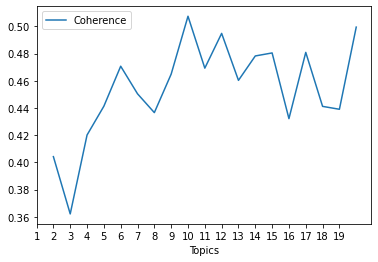

In [67]:
# Topics-Coherence plot

lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))

In [18]:
# Running LDA with tuned number of topics (10)

%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=10,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, \
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs

Coherence Score:  0.40195361820636855


In [19]:
%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/

In [20]:
pyLDAvis.display(lda_display)

In [21]:
pprint(tuned_lda_model.print_topics())

[(0,
  '0.005*"product" + 0.004*"additional_shares_last_quarter" + '
  '0.004*"owns_shares_industrial_product" + 0.003*"shares_illinois_tool_work" '
  '+ 0.003*"industrial_products_company_stock" + 0.003*"total_transaction" + '
  '0.003*"share" + 0.003*"ratio_debt_equity_ratio" + '
  '0.003*"ex_dividend_date_dividend" + '
  '0.002*"represents_dividend_annualized_basis"'),
 (1,
  '0.008*"also" + 0.005*"city" + 0.005*"area" + 0.004*"home" + '
  '0.004*"restaurant" + 0.004*"park" + 0.003*"food" + 0.003*"read" + '
  '0.003*"well" + 0.003*"roof_covere"'),
 (2,
  '0.009*"say" + 0.007*"go" + 0.007*"team" + 0.006*"time" + 0.005*"make" + '
  '0.005*"also" + 0.005*"get" + 0.005*"year" + 0.005*"game" + 0.005*"season"'),
 (3,
  '0.002*"time" + 0.002*"order" + 0.001*"аnd" + 0.001*"pay" + 0.001*"section" '
  '+ 0.001*"year" + 0.001*"child" + 0.001*"quote" + 0.001*"youngster" + '
  '0.001*"court"'),
 (4,
  '0.029*"say" + 0.008*"state" + 0.006*"school" + 0.005*"people" + '
  '0.005*"city" + 0.004*"stu

In [22]:
# Since there is some overlap in topics, we go with 9 topics

%time

tuned_lda_model_2 = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=9,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model_2, texts=data_lemmatized, dictionary=dictionary, \
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.3 µs

Coherence Score:  0.41854606788283405


In [23]:
%time

lda_display_2 = gensimvis.prepare(tuned_lda_model_2, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/

In [24]:
pyLDAvis.display(lda_display_2)

In [25]:
pprint(tuned_lda_model_2.print_topics())

[(0,
  '0.004*"product" + 0.004*"additional_shares_last_quarter" + '
  '0.003*"owns_shares_industrial_product" + '
  '0.003*"industrial_products_company_stock" + 0.003*"total_transaction" + '
  '0.003*"shares_illinois_tool_work" + 0.003*"share" + '
  '0.002*"ratio_debt_equity_ratio" + 0.002*"ex_dividend_date_dividend" + '
  '0.002*"represents_dividend_annualized_basis"'),
 (1,
  '0.008*"also" + 0.004*"restaurant" + 0.004*"roof_covere" + 0.004*"roof" + '
  '0.004*"well" + 0.004*"area" + 0.003*"home" + 0.003*"food" + 0.003*"city" + '
  '0.003*"park"'),
 (2,
  '0.010*"say" + 0.007*"go" + 0.006*"team" + 0.005*"time" + 0.005*"also" + '
  '0.005*"make" + 0.005*"year" + 0.005*"get" + 0.005*"game" + 0.005*"come"'),
 (3,
  '0.002*"time" + 0.002*"order" + 0.001*"family_lawyers_near" + 0.001*"аnd" + '
  '0.001*"section" + 0.001*"pay" + 0.001*"child" + '
  '0.001*"report_created_automatically_weather" + 0.001*"court" + '
  '0.001*"points_rebounds_assists_steal"'),
 (4,
  '0.029*"say" + 0.008*"stat